# Predicting Goal Success for the Maple Leafs
___

In [32]:
import psycopg2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn import svm, preprocessing, pipeline, set_config, compose, model_selection, ensemble, metrics
import pickle
set_config(display='diagram')

### Data Preparation
___

In [33]:
# create connection to database
connection = psycopg2.connect(
    host="localhost",
    database="50_in_07",
    user="tanyatang")

In [34]:
# select relevant data from database
cursor = connection.cursor()
cursor.execute(
    """
    WITH data AS (SELECT CONCAT(players.first_name, ' ', players.last_name) as full_name
                       , players.primary_position
                       , players.height
                       , players.weight
                       , teams0.name AS opposing_team
                       , teams2.name AS away_team
                       , teams1.name AS home_team
                       , game_play_players.play_player_type
                       , game_plays.play_type
                       , game_plays.period_type
                       , game_plays.away_team_goals
                       , game_plays.home_team_goals
                       , game_plays.x_coordinate
                       , game_plays.y_coordinate
                    FROM players
                    JOIN game_play_players
                      ON players.id = game_play_players.player_id
                    JOIN game_plays
                      ON (game_play_players.game_id = game_plays.game_id
                          AND game_play_players.play_num = game_plays.play_num)
                    JOIN games
                      ON game_plays.game_id = games.id
                    JOIN teams AS teams0
                      ON (games.home_team_id + games.away_team_id - 10) = teams0.id
                    JOIN teams AS teams1
                      ON games.home_team_id = teams1.id
                    JOIN teams AS teams2
                      ON games.away_team_id = teams2.id
                   WHERE x_coordinate IS NOT NULL
                     AND y_coordinate IS NOT NULL
                     AND games.season_id > 20142015)
          SELECT row_to_json(data.*)
            FROM data
    """)
results = cursor.fetchall()
cursor.close()

In [35]:
# close connection
connection.close()

In [36]:
# add ratio of leafs goals to total goals per play
all_data = list(map(lambda x: x[0], results))
goal_data = list(filter(lambda x: (x['play_type'] == 'Goal' or
                                   x['play_type'] == 'Shot' or
                                   x['play_type'] == 'Blocked Shot' or
                                   x['play_type'] == 'Missed Shot') and
                                   x['play_player_type'] != 'Goalie' and
                                   x['play_player_type'] != 'Unknown' and 
                                   x['play_player_type'] != 'Assist' and
                                   x['play_player_type'] != 'Blocker', all_data))
for play in goal_data:
    play['height'] = play['height'].split('-')[0] * 12 + play['height'].split('-')[1]
    if play['opposing_team'] == play['home_team']:
        if play['home_team_goals'] == 0:
            play['goal_ratio'] = 1
        else:
            play['goal_ratio'] = play['away_team_goals'] / (play['home_team_goals'] + play['away_team_goals'])
    elif play['opposing_team'] == play['away_team']:
        if play['away_team_goals'] == 0:
            play['goal_ratio'] = 1
        else:
            play['goal_ratio'] = play['home_team_goals'] / (play['away_team_goals'] + play['home_team_goals'])
    else:
        print('Error')
    play.pop('away_team_goals')
    play.pop('away_team')
    play.pop('home_team_goals')
    play.pop('home_team')
    play.pop('play_type')

In [37]:
# create pandas dataframe
goal_data = pd.json_normalize(goal_data)
print(goal_data.head(5))

          full_name primary_position         height  weight   opposing_team  \
0  William Nylander       Right Wing  6666666666660     196  Buffalo Sabres   
1  William Nylander       Right Wing  6666666666660     196  Buffalo Sabres   
2   Mitchell Marner       Right Wing  6666666666660     175  Buffalo Sabres   
3  William Nylander       Right Wing  6666666666660     196  Buffalo Sabres   
4  William Nylander       Right Wing  6666666666660     196  Buffalo Sabres   

  play_player_type period_type  x_coordinate  y_coordinate  goal_ratio  
0           Scorer     REGULAR            61            -3    1.000000  
1          Shooter     REGULAR           -35           -31    0.833333  
2          Shooter     REGULAR           -60            -3    0.833333  
3          Shooter     REGULAR            46            -8    0.888889  
4          Shooter     REGULAR            49            30    0.888889  


### Data Visualization
___

In [38]:
# set maplotlib parameters
plt.style.use('ggplot')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.rcParams['figure.figsize'] = (10, 6)

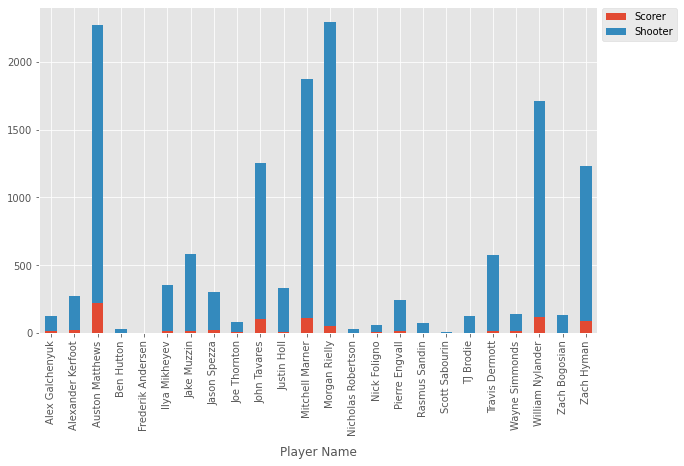

In [39]:
# plot distribution of unsuccesful shots and goals for players
goals_per_player = goal_data.groupby(['full_name', 'play_player_type'])['full_name']
ax = goals_per_player.count().unstack().plot(kind='bar', stacked=True)
ax.set_xlabel('Player Name', labelpad=10)
ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.88))
plt.show()

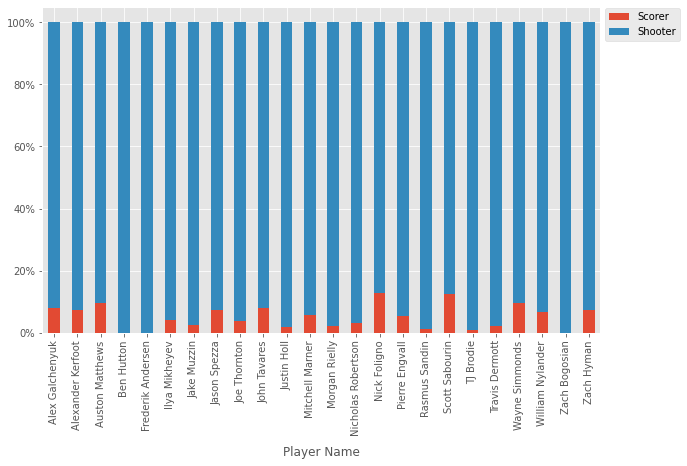

In [40]:
# plot normalized split between success and failure for each player
ax = goals_per_player.count().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar', stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Player Name', labelpad=10)
ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.88))
plt.show()

### Data Preprocessing
___

In [41]:
# separate data into X and y sets
X = goal_data.loc[:, goal_data.columns != 'play_player_type']
y = goal_data['play_player_type']

In [42]:
# binarize classes
binarizer = preprocessing.LabelBinarizer()
binarizer.fit(['Scorer', 'Shooter'])
y = binarizer.transform(y)

In [43]:
# encode categorical features
# all data has been verified and cleaned before so there are no missing or unknown values
categorical_features = ['full_name', 'primary_position', 'opposing_team', 'period_type']
categorical_transformer = preprocessing.OneHotEncoder(handle_unknown='ignore')

In [44]:
# normalize numerical features
# all data has been verified and cleaned before so there are no missing or unknown values
numerical_features = ['height', 'weight', 'x_coordinate', 'y_coordinate', 'goal_ratio']
numerical_transformer = preprocessing.StandardScaler()

In [45]:
# create column transformer that applies both numerical and categorical transformers
preprocessor = compose.ColumnTransformer(
    transformers = [
        ('categorical', categorical_transformer, categorical_features),
        ('numerical', numerical_transformer, numerical_features)
    ]
)

In [46]:
# split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.4, random_state=0
)
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(
    X_test, y_test, test_size=0.6, random_state=0
)

### Support Vector Machine Classification
___

In [47]:
# parameters
param_grid_svm = {
    'C': [1, 10, 100],
    'gamma': [0.1, 0.01, 0.001]
}
best_c_value = 0
best_gamma_value = 0
best_fbeta_score = 0
# set beta for f beta score to favour recall
beta_svm = 1.6
# train models and tune hyperparameters
for c_value in param_grid_svm['C']:
    for gamma_value in param_grid_svm['gamma']:
        # create model
        model_svm = svm.SVC(C=c_value, gamma=gamma_value, kernel='rbf', class_weight='balanced')
        # create pipeline
        pipeline_svm = pipeline.Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model_svm)
        ])
        # train model
        pipeline_svm.fit(X_train, np.ravel(y_train))
        # predict validation data
        y_pred = pipeline_svm.predict(X_valid)
        # calculate f beta score
        fbeta_score = metrics.fbeta_score(y_valid, y_pred, beta=beta_svm)
        # record best parameters
        if fbeta_score > best_fbeta_score:
            best_c_value = c_value
            best_gamma_value = gamma_value
            best_fbeta_score = fbeta_score
        print(f'C = {c_value}, gamma = {gamma_value}, F-beta score = {fbeta_score}')
print(f'The model has an F-beta score of {best_fbeta_score} '
      f'with C = {best_c_value} and gamma = {best_gamma_value}')

C = 1, gamma = 0.1, F-beta score = 0.7482843222349524
C = 1, gamma = 0.01, F-beta score = 0.5635531464931811
C = 1, gamma = 0.001, F-beta score = 0.5358895398327574
C = 10, gamma = 0.1, F-beta score = 0.8236814224773394
C = 10, gamma = 0.01, F-beta score = 0.6524981536299934
C = 10, gamma = 0.001, F-beta score = 0.5322399854721246
C = 100, gamma = 0.1, F-beta score = 0.8817614670873132
C = 100, gamma = 0.01, F-beta score = 0.7392000835785553
C = 100, gamma = 0.001, F-beta score = 0.5900806050597631
The model has an F-beta score of 0.8817614670873132 with C = 100 and gamma = 0.1


In [48]:
# modify pipeline with new parameters
model_svm = svm.SVC(C=best_c_value, gamma=best_gamma_value, kernel='rbf', class_weight='balanced')
pipeline_svm = pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model_svm)
])
pipeline_svm.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['full_name',
                                                   'primary_position',
                                                   'opposing_team',
                                                   'period_type']),
                                                 ('numerical', StandardScaler(),
                                                  ['height', 'weight',
                                                   'x_coordinate',
                                                   'y_coordinate',
                                                   'goal_ratio'])])),
                ('classifier', SVC(C=100, class_weight='balanced', gamma=0.1))])

In [49]:
# predict test data and obtain f beta score
y_pred = pipeline_svm.predict(X_test)
fbeta_score = metrics.fbeta_score(y_test, y_pred, beta=beta_svm)
print(f'The model has an F-beta score of {fbeta_score} when making predictions using test data')

The model has an F-beta score of 0.8727149701912879 when making predictions using test data


### Random Forest Classification
___

In [50]:
# parameters
param_grid_rf = {
    'max_depth': [10, 30, 50],
    'min_samples_leaf': [1, 3, 5],
    'n_estimators': [10, 50, 100]
}
best_depth_value = 0
best_leaf_value = 0
best_estimator_value = 0
best_fbeta_score = 0
# set beta for f beta score to favour precision
beta_rf = 0.3
# train models and tune hyperparameters
for depth_value in param_grid_rf['max_depth']:
    for leaf_value in param_grid_rf['min_samples_leaf']:
        for estimator_value in param_grid_rf['n_estimators']:
            # create model
            model_rf = ensemble.RandomForestClassifier(max_depth=depth_value,
                                                       min_samples_leaf=leaf_value,
                                                       n_estimators=estimator_value,
                                                       class_weight='balanced',
                                                       random_state=0)
            # create pipeline
            pipeline_rf = pipeline.Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', model_rf)
            ])
            # train model
            pipeline_rf.fit(X_train, np.ravel(y_train))
            # predict validation data
            y_pred = pipeline_rf.predict(X_valid)
            # calculate f beta score
            fbeta_score = metrics.fbeta_score(y_valid, y_pred, beta=beta_rf)
            # record best parameters
            if fbeta_score > best_fbeta_score:
                best_depth_value = depth_value
                best_leaf_value = leaf_value
                best_estimator_value = estimator_value
                best_fbeta_score = fbeta_score
            print(f'Depth = {depth_value}, leaf = {leaf_value}, '
                  f'estimators = {estimator_value}, F-beta score = {fbeta_score}')
print(f'The model has an F-beta score of {best_fbeta_score} with max depth = {best_depth_value} '
      f'and min samples leaf = {best_leaf_value} and number of estimators = {best_estimator_value}')

Depth = 10, leaf = 1, estimators = 10, F-beta score = 0.9369331728948014
Depth = 10, leaf = 1, estimators = 50, F-beta score = 0.9419260786661345
Depth = 10, leaf = 1, estimators = 100, F-beta score = 0.9434341668123799
Depth = 10, leaf = 3, estimators = 10, F-beta score = 0.9378644190847836
Depth = 10, leaf = 3, estimators = 50, F-beta score = 0.941040088884858
Depth = 10, leaf = 3, estimators = 100, F-beta score = 0.9415164201949265
Depth = 10, leaf = 5, estimators = 10, F-beta score = 0.9391785969523019
Depth = 10, leaf = 5, estimators = 50, F-beta score = 0.9397422238691898
Depth = 10, leaf = 5, estimators = 100, F-beta score = 0.9408052745831602
Depth = 30, leaf = 1, estimators = 10, F-beta score = 0.9449997490673671
Depth = 30, leaf = 1, estimators = 50, F-beta score = 0.9440951971847277
Depth = 30, leaf = 1, estimators = 100, F-beta score = 0.9434973290245996
Depth = 30, leaf = 3, estimators = 10, F-beta score = 0.9459108376783879
Depth = 30, leaf = 3, estimators = 50, F-beta sc

In [51]:
# modify pipeline with new parameters
model_rf = ensemble.RandomForestClassifier(max_depth=best_depth_value, 
                                           min_samples_leaf=best_leaf_value,
                                           n_estimators=best_estimator_value,
                                           class_weight='balanced',
                                           random_state=0)
pipeline_rf = pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model_rf)
])
pipeline_rf.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['full_name',
                                                   'primary_position',
                                                   'opposing_team',
                                                   'period_type']),
                                                 ('numerical', StandardScaler(),
                                                  ['height', 'weight',
                                                   'x_coordinate',
                                                   'y_coordinate',
                                                   'goal_ratio'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=50,
                                        min_samples_leaf=5, n_estimators=50,
                                        random_state=0))])

In [52]:
# predict test data and obtain f beta score
y_pred = pipeline_rf.predict(X_test)
fbeta_score = metrics.fbeta_score(y_test, y_pred, beta=beta_rf)
print(f'The model has an F-beta score of {fbeta_score} when making predictions using test data')

The model has an F-beta score of 0.9468245095486778 when making predictions using test data


### Results and Analysis
___

C: 100
gamma: 0.1


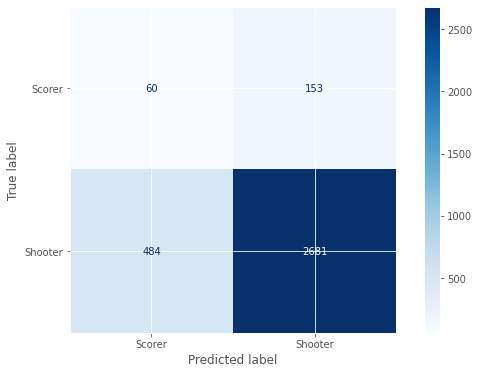

In [53]:
# confusion matrix for svm model with best hyperparameters on test data
print('C:', best_c_value)
print('gamma:', best_gamma_value)
disp = metrics.plot_confusion_matrix(pipeline_svm,
                                     X_test,
                                     y_test,
                                     display_labels=['Scorer', 'Shooter'],
                                     cmap=plt.cm.Blues)

C: 100
gamma: 0.1


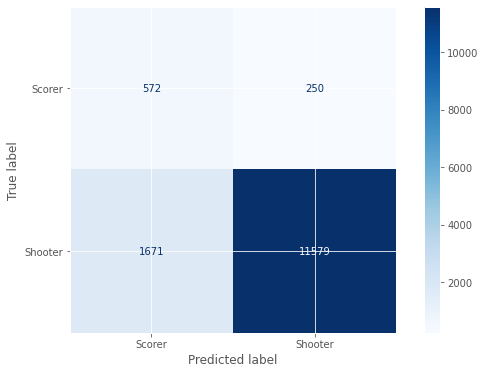

In [54]:
# confusion matrix for svm model with best hyperparameters on all data
print('C:', best_c_value)
print('gamma:', best_gamma_value)
disp = metrics.plot_confusion_matrix(pipeline_svm,
                                     X,
                                     y,
                                     display_labels=['Scorer', 'Shooter'],
                                     cmap=plt.cm.Blues)

Max Depth: 50
Min Samples Leaf: 5
Number of Estimators: 50


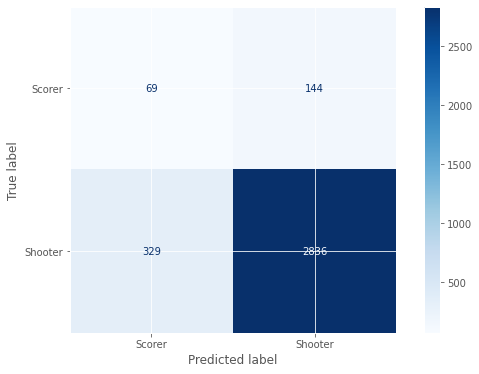

In [55]:
# confusion matrix for rf model with best hyperparameters on test data
print('Max Depth:', best_depth_value)
print('Min Samples Leaf:', best_leaf_value)
print('Number of Estimators:', best_estimator_value)
disp = metrics.plot_confusion_matrix(pipeline_rf,
                                     X_test,
                                     y_test,
                                     display_labels=['Scorer', 'Shooter'],
                                     cmap=plt.cm.Blues)

Max Depth: 50
Min Samples Leaf: 5
Number of Estimators: 50


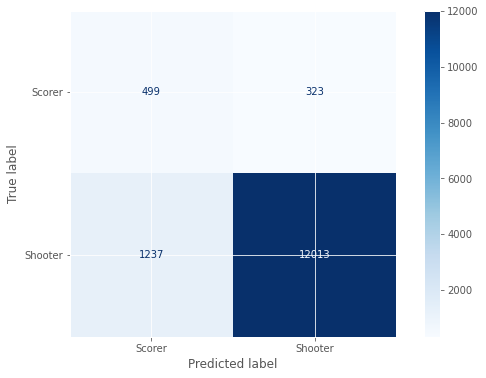

In [56]:
# confusion matrix for rf model with best hyperparameters on all data
print('Max Depth:', best_depth_value)
print('Min Samples Leaf:', best_leaf_value)
print('Number of Estimators:', best_estimator_value)
disp = metrics.plot_confusion_matrix(pipeline_rf,
                                     X,
                                     y,
                                     display_labels=['Scorer', 'Shooter'],
                                     cmap=plt.cm.Blues)

### Model Export
___

In [57]:
# save svm model to disk
pickle.dump(pipeline_svm, open('../api/models/classification_pipeline_svm.pkl', 'wb'))
# save rf model to disk
pickle.dump(pipeline_rf, open('../api/models/classification_pipeline_rf.pkl', 'wb'))